In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
# Setting working directory
import json
with open('setup.json', 'r') as openfile:
    setup_object = json.load(openfile)
    WD = setup_object["wd_path"]

In [3]:
# matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.family'] = 'DeJavu Serif'
matplotlib.rcParams['font.serif'] = ['Times New Roman']
matplotlib.rcParams['font.size'] = 10

In [4]:
Ms = [5, 10]

For exploratory inter-flow analysis we caculated all the fully and partially covering flow and performed analyses.

We calculated statistics for common covering flows (without any special characteristics) and for the following features:
- covering flows that have the same application category as the target
- covering flows that have the same application type as the target
- covering flows that have SD events
- covering flows that have the same application category as the target and have SD events
- covering flows that have the same application type as the target and have SD events

In [5]:
dfs = []
for M in Ms:
    dfs.append(pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet'))

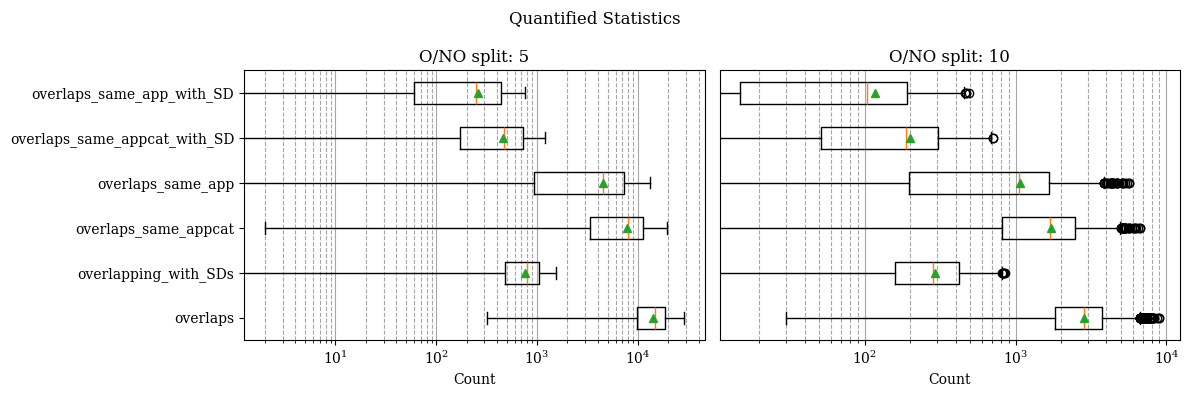

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for M, df, a in zip(Ms, dfs, ax.flatten()):
    df_with_overlaps = df[df['overlapping_rel_idxs'].apply(len) > 0]
    datas = [df_with_overlaps['count_overlaps'], df_with_overlaps['count_overlapping_SDs'],
             df_with_overlaps['count_overlaps_same_appcat'], df_with_overlaps['count_overlaps_same_app'],
             df_with_overlaps['count_overlaps_same_appcat_with_SD'], df_with_overlaps['count_overlaps_same_app_with_SD']]
    a.boxplot(datas, showmeans=True, vert=False)
    a.set_xscale('log')
    a.set_xlabel('Count')
    if M == 5:
        a.set_yticks([i + 1 for i in range(6)])
        a.set_yticklabels(['overlaps', 'overlapping_with_SDs', 'overlaps_same_appcat',
                                                      'overlaps_same_app', 'overlaps_same_appcat_with_SD',
                                                      'overlaps_same_app_with_SD'])
    else:
        a.set_yticks([])
    a.set_title(f"O/NO split: {M}")
    a.grid(True, which="minor", ls="--", c='0.65', axis='x')
    a.grid(True, which="major", ls="-", c='0.65', axis='x')
fig.tight_layout()
# plt.savefig(f"plots/inter_stats_used/quantified_statstics.pdf")
# plt.savefig(f"plots/inter_stats_used/quantified_statstics.png", dpi=500)
fig.suptitle("Quantified Statistics")
fig.tight_layout()
# plt.savefig(f"plots/inter_stats_used/quantified_statstics.svg")
plt.show()

In [7]:
for df in dfs:
    del df
del dfs

In [8]:
matplotlib.rcParams['font.size'] = 11

In [18]:
def plot_boxplots_ecdfs(xlabel, title, filename, get_datas, to_plot, labels,
                        log_xscale=False, showfliers=True, width_ratios=[1.6, 1],
                        legend_inside_axis=False, title_loc=0.7, fig_height=7):    
    fig = plt.figure(constrained_layout=True, figsize=(16, fig_height))
    subfigs = fig.subfigures(nrows=1, ncols=2, width_ratios=width_ratios)
    
    for M, subfig in zip(Ms, subfigs.flat):
        datas = get_datas(filename, M, to_plot)
        ax_box, ax_ecdf = subfig.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.40, .60),
                                                                      })
        ax_box.set_title(f'O/NO split: {M}')
        
        for idx in range(len(to_plot)):
            data = datas[idx]
            data_ecdf = ECDF(data)
            if M == 5:
                ax_ecdf.plot(data_ecdf.x, data_ecdf.y, ls='-', label=labels[idx])
            else:
                ax_ecdf.plot(data_ecdf.x, data_ecdf.y, ls='-')
        
        ax_ecdf.grid(True, which="minor", ls="--", c='0.65', axis='x')
        ax_ecdf.grid(True, which="major", ls="-", c='0.65', axis='x')
        ax_ecdf.set_xlabel(xlabel)
        ax_ecdf.set_ylabel('Proportion')
    
        ax_box.boxplot(datas, showmeans=True, vert=False, showfliers=showfliers)
        if log_xscale:
            ax_box.set_xscale('log')
        if M == 5:
            if legend_inside_axis:
                ax_ecdf.legend()
            else:
                ax_ecdf.legend(bbox_to_anchor=(-.3, .5), loc='center')
            # ax_box.set_yticks([i + 1 for i in range(len(labels))], labels=labels)
            ax_box.set_yticks([i + 1 for i in range(len(labels))])
            ax_box.set_yticklabels(labels)
            # subfig.suptitle(f'O/NO split: {M}', x=title_loc)
        else:
            ax_box.set_yticklabels([])
            ax_box.set_yticks([])
            # ax_ecdf.set_yticks(ax_ecdf.get_yticks(), labels=[" "] * len(ax_ecdf.get_yticks()))
            ax_ecdf.set_yticks(ax_ecdf.get_yticks())
            ax_ecdf.set_yticklabels([" "] * len(ax_ecdf.get_yticks()))
            ax_ecdf.set_ylim(-0.05, 1.05)
            ax_ecdf.set_ylabel('')
            
        ax_box.grid(True, which="minor", ls="--", c='0.65', axis='x')
        ax_box.grid(True, which="major", ls="-", c='0.65', axis='x')

        del datas

    fig.suptitle("", y=1.05)
    # plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    # plt.savefig(f"{filename}.png", dpi=500, bbox_inches='tight')
    fig.suptitle(title, y=1.05)
    # plt.savefig(f"{filename}.svg", bbox_inches='tight')
    plt.show()

In [10]:
def get_datas_min(filename, M, to_plot):
    plot_list = []
    for feature in to_plot:
        df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=[feature])
        plot_list.append(df[df[feature].apply(len) > 0][feature].apply(min).to_list())
        del df
    return plot_list

def get_datas_all(filename, M, to_plot):
    plot_list = []
    for feature in to_plot:
        df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=[feature])
        plot_list.append([item for row in df[feature].to_list() for item in row])
        del df
    return plot_list

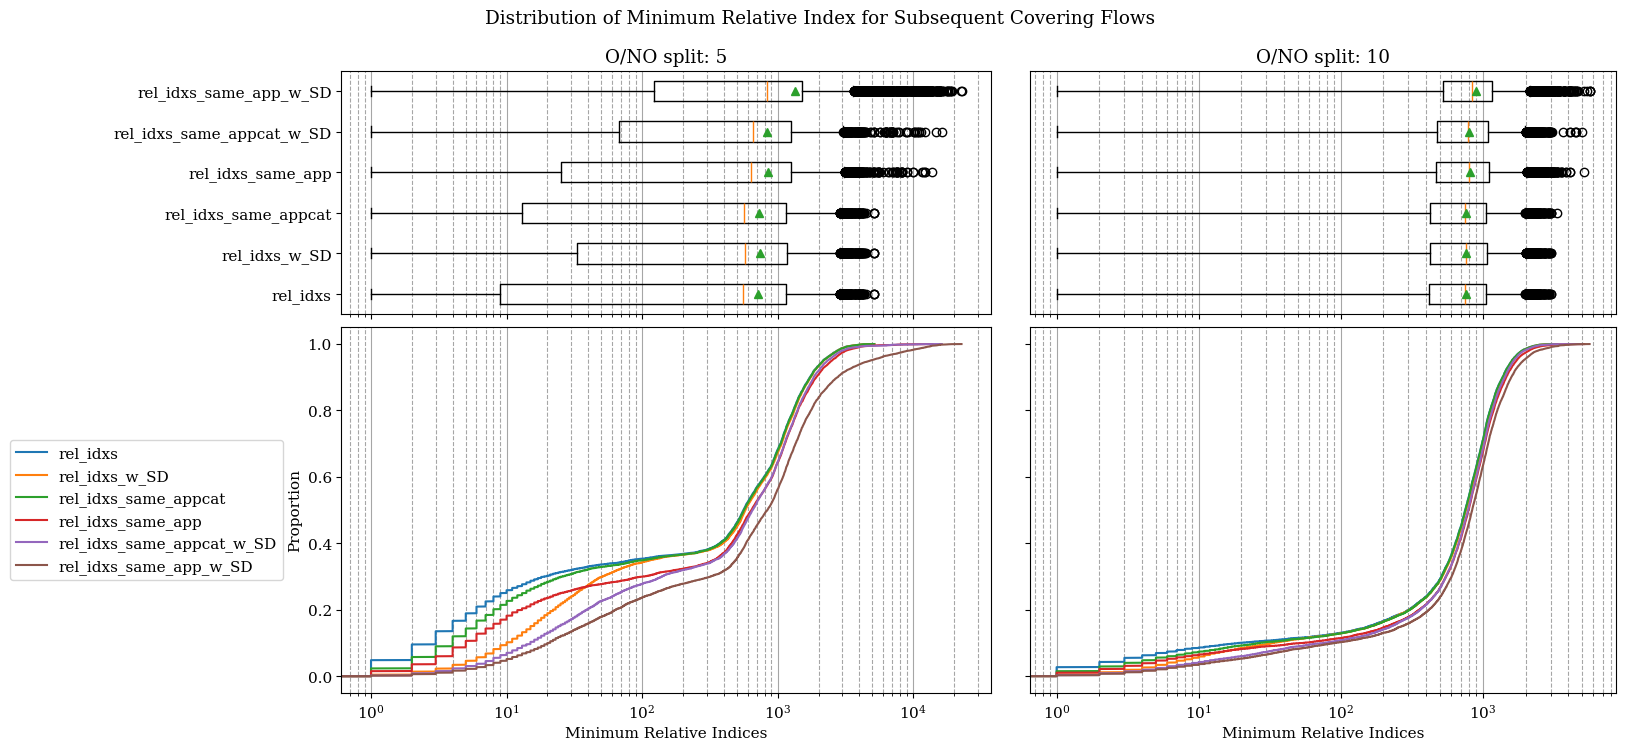

In [19]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Indices',
                    title='Distribution of Minimum Relative Index for Subsequent Covering Flows',
                    filename='plots/inter_stats_used/minimum_relative_indices',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_idxs', 'overlapping_rel_idxs_with_SD', 'overlapping_rel_idxs_same_appcat',
                               'overlapping_rel_idxs_same_app', 'overlapping_rel_idxs_same_appcat_with_SD', 'overlapping_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs', 'rel_idxs_w_SD', 'rel_idxs_same_appcat',
                              'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    log_xscale=True
                   )

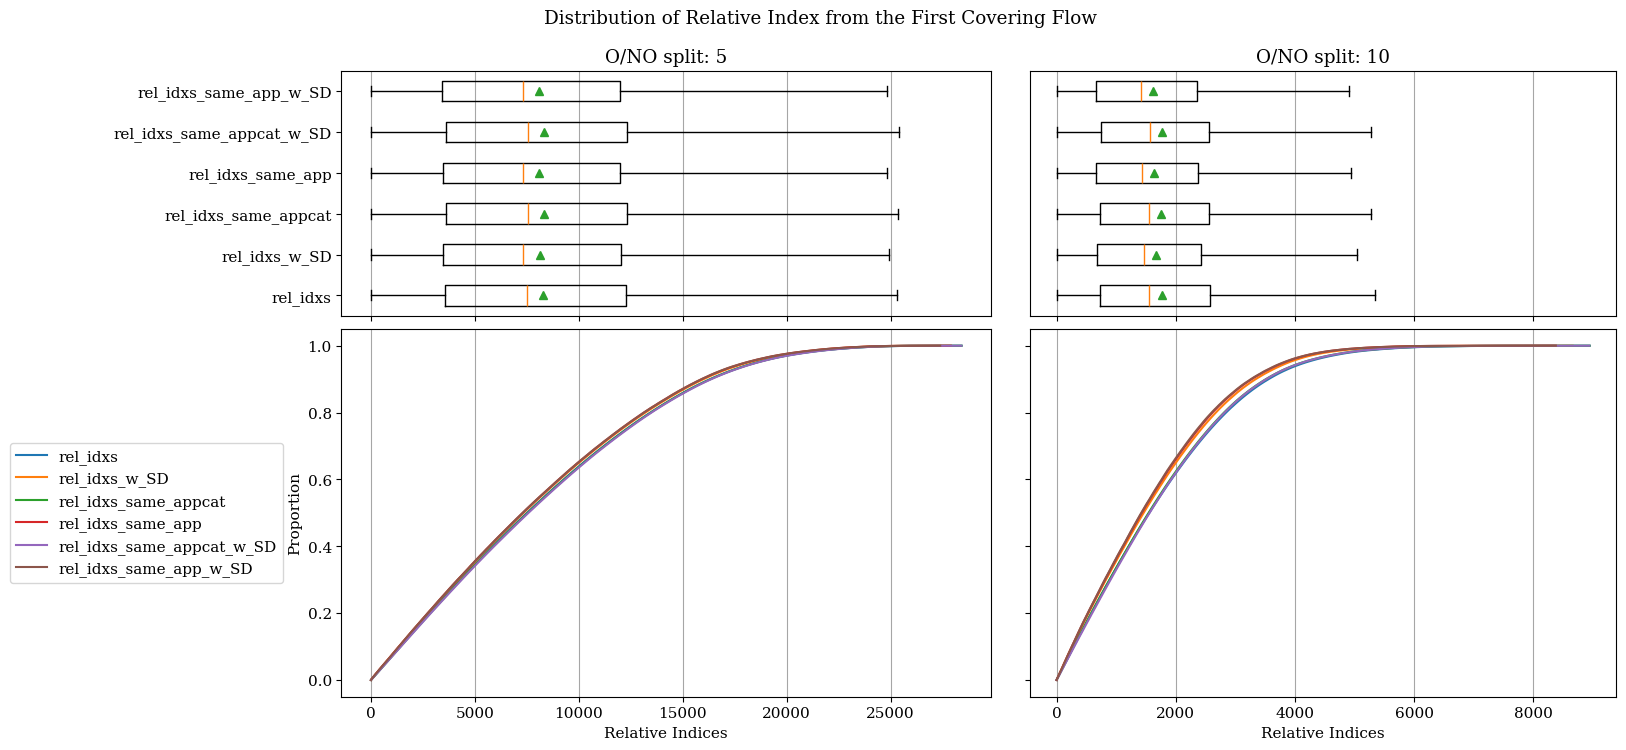

In [24]:
plot_boxplots_ecdfs(xlabel='Relative Indices',
                    title='Distribution of Relative Index from the First Covering Flow',
                    filename='plots/inter_stats_used/relative_from_cover_start',
                    get_datas=get_datas_all,
                    to_plot = ['overlapping_rel_to_rel_idxs', 'overlapping_rel_to_rel_idxs_with_SD',
                               'overlapping_rel_to_rel_idxs_same_appcat', 'overlapping_rel_to_rel_idxs_same_appcat_with_SD',
                               'overlapping_rel_to_rel_idxs_same_app', 'overlapping_rel_to_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs', 'rel_idxs_w_SD', 'rel_idxs_same_appcat',
                               'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    showfliers=False
                   )

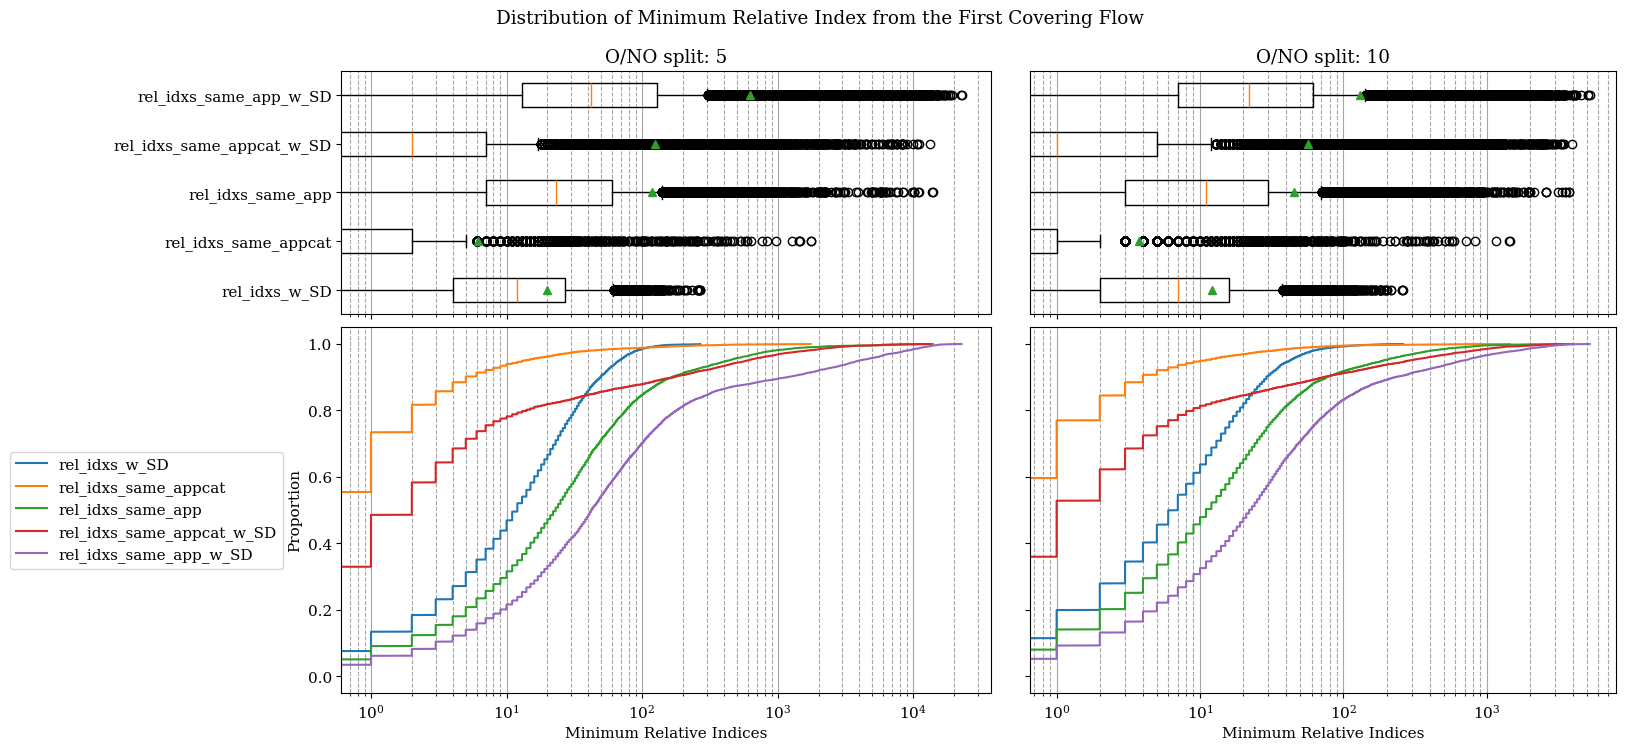

In [25]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Indices',
                    title='Distribution of Minimum Relative Index from the First Covering Flow',
                    filename='plots/inter_stats_used/minimum_relative_from_cover_start',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_to_rel_idxs_with_SD',
                       'overlapping_rel_to_rel_idxs_same_appcat', 'overlapping_rel_to_rel_idxs_same_appcat_with_SD',
                       'overlapping_rel_to_rel_idxs_same_app', 'overlapping_rel_to_rel_idxs_same_app_with_SD'],
                    labels = ['rel_idxs_w_SD', 'rel_idxs_same_appcat',
                               'rel_idxs_same_app', 'rel_idxs_same_appcat_w_SD', 'rel_idxs_same_app_w_SD'],
                    log_xscale=True
                   )

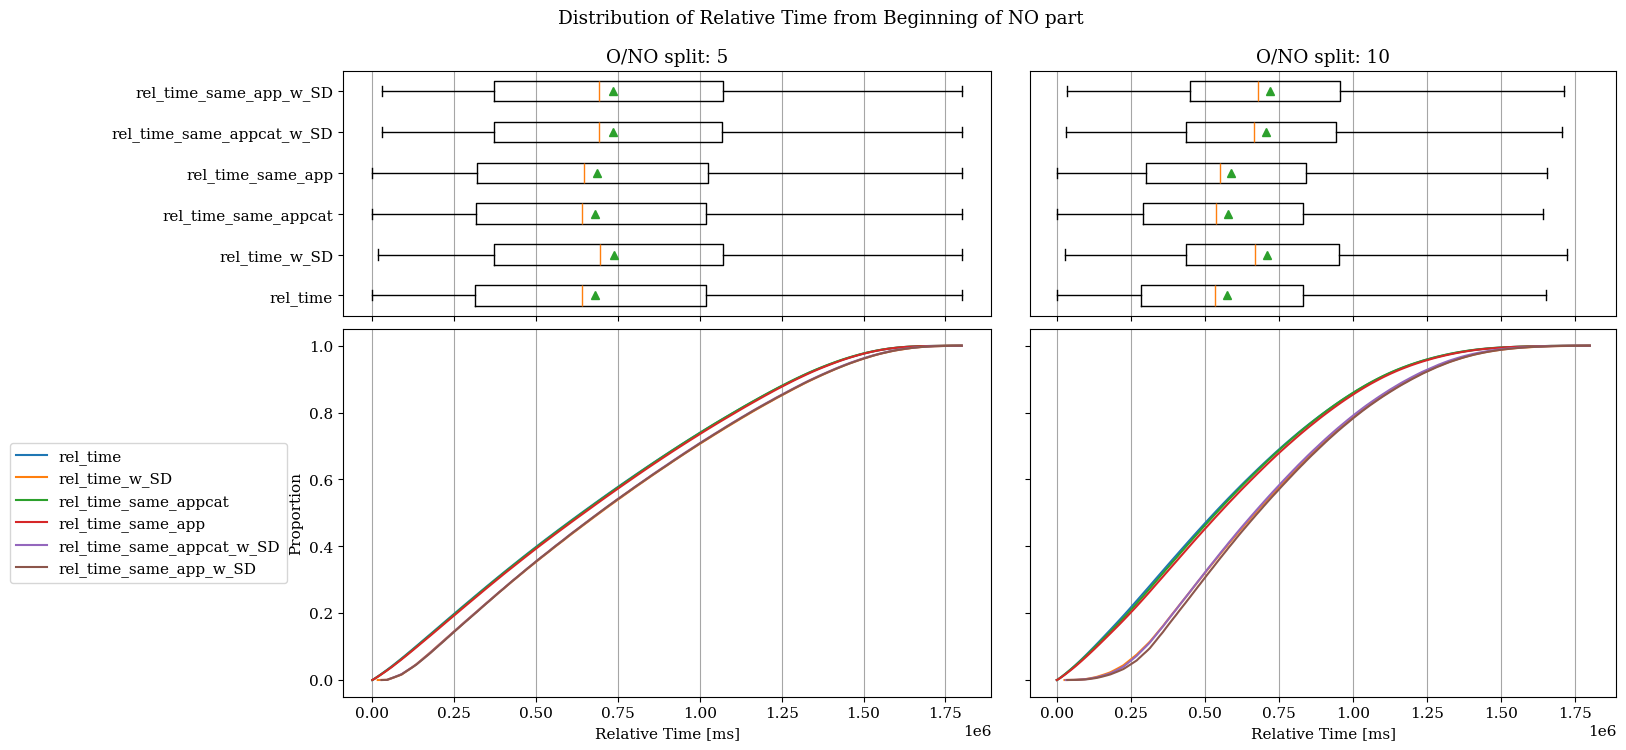

In [30]:
plot_boxplots_ecdfs(xlabel='Relative Time [ms]',
                    title='Distribution of Relative Time from Beginning of NO part',
                    filename='plots/inter_stats_used/relative_time',
                    get_datas=get_datas_all,
                    to_plot = ['overlapping_rel_time',
                           'overlapping_rel_time_with_SD', 'overlapping_rel_time_same_appcat',
                           'overlapping_rel_time_same_app',
                           'overlapping_rel_time_same_appcat_with_SD',
                           'overlapping_rel_time_same_app_with_SD'],
                    labels = ['rel_time', 'rel_time_w_SD', 'rel_time_same_appcat',
                               'rel_time_same_app', 'rel_time_same_appcat_w_SD', 'rel_time_same_app_w_SD'],
                    showfliers=False,
                   )

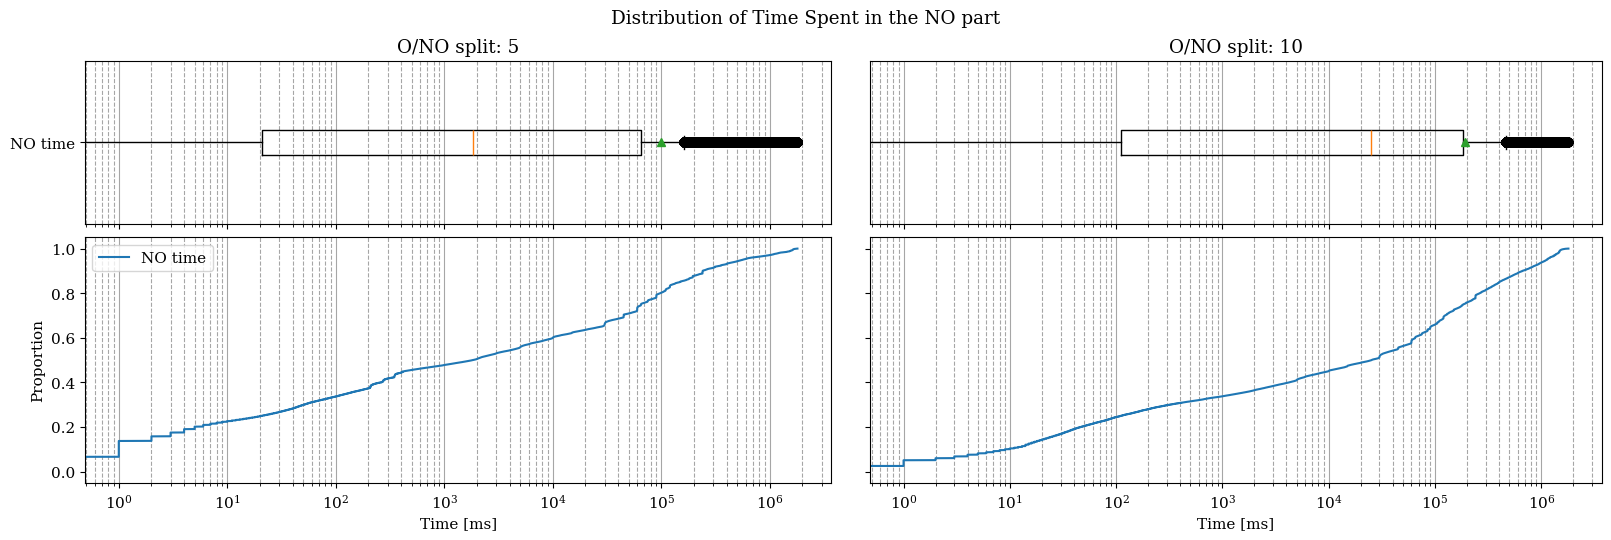

In [28]:
def get_NO_len(filename, M, to_plot):
    df = pd.read_parquet(f'{WD}/inter_stats_used/M{M}.parquet', columns=['NO_delay', 'NO_timestamps'])
    df = df[df['NO_delay'].apply(len) > 0]
    return [df.apply(lambda row: (row['NO_timestamps'][-1] + row['NO_delay'][-1]) - row['NO_timestamps'][0], axis=1).to_list()]

plot_boxplots_ecdfs(xlabel='Time [ms]',
                    title='Distribution of Time Spent in the NO part',
                    filename='plots/inter_stats_used/NO_time',
                    get_datas=get_NO_len,
                    to_plot = ['NO_time'],
                    labels = ['NO time'],
                    width_ratios=[1.1, 1],
                    legend_inside_axis=True,
                    log_xscale=True,
                    title_loc=0.6,
                    fig_height=5
                   )

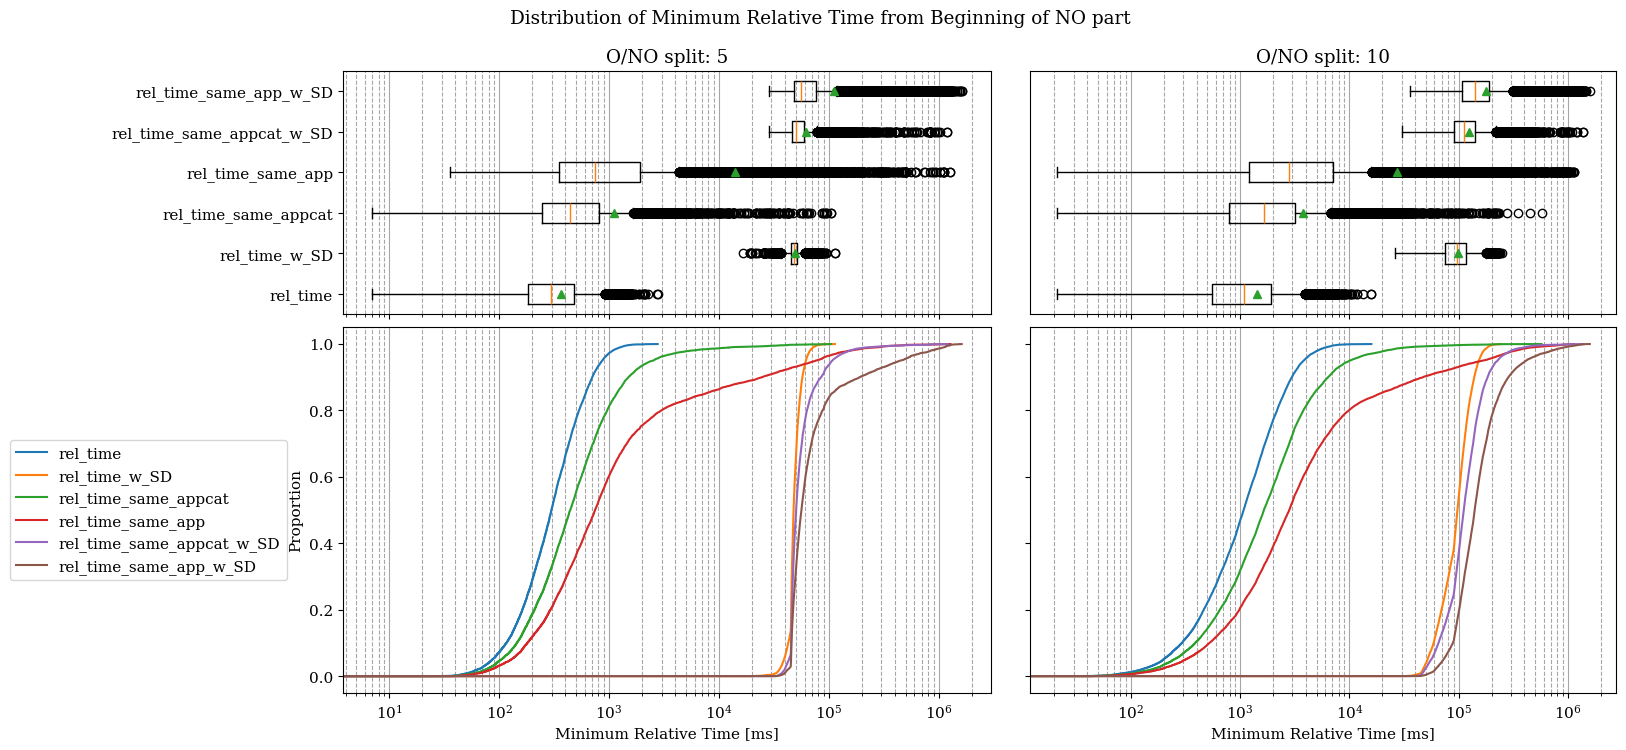

In [29]:
plot_boxplots_ecdfs(xlabel='Minimum Relative Time [ms]',
                    title='Distribution of Minimum Relative Time from Beginning of NO part',
                    filename='plots/inter_stats_used/minimum_relative_time',
                    get_datas=get_datas_min,
                    to_plot = ['overlapping_rel_time',
                           'overlapping_rel_time_with_SD', 'overlapping_rel_time_same_appcat',
                           'overlapping_rel_time_same_app',
                           'overlapping_rel_time_same_appcat_with_SD',
                           'overlapping_rel_time_same_app_with_SD'],
                    labels = ['rel_time', 'rel_time_w_SD', 'rel_time_same_appcat',
                               'rel_time_same_app', 'rel_time_same_appcat_w_SD', 'rel_time_same_app_w_SD'],
                    log_xscale=True
                   )

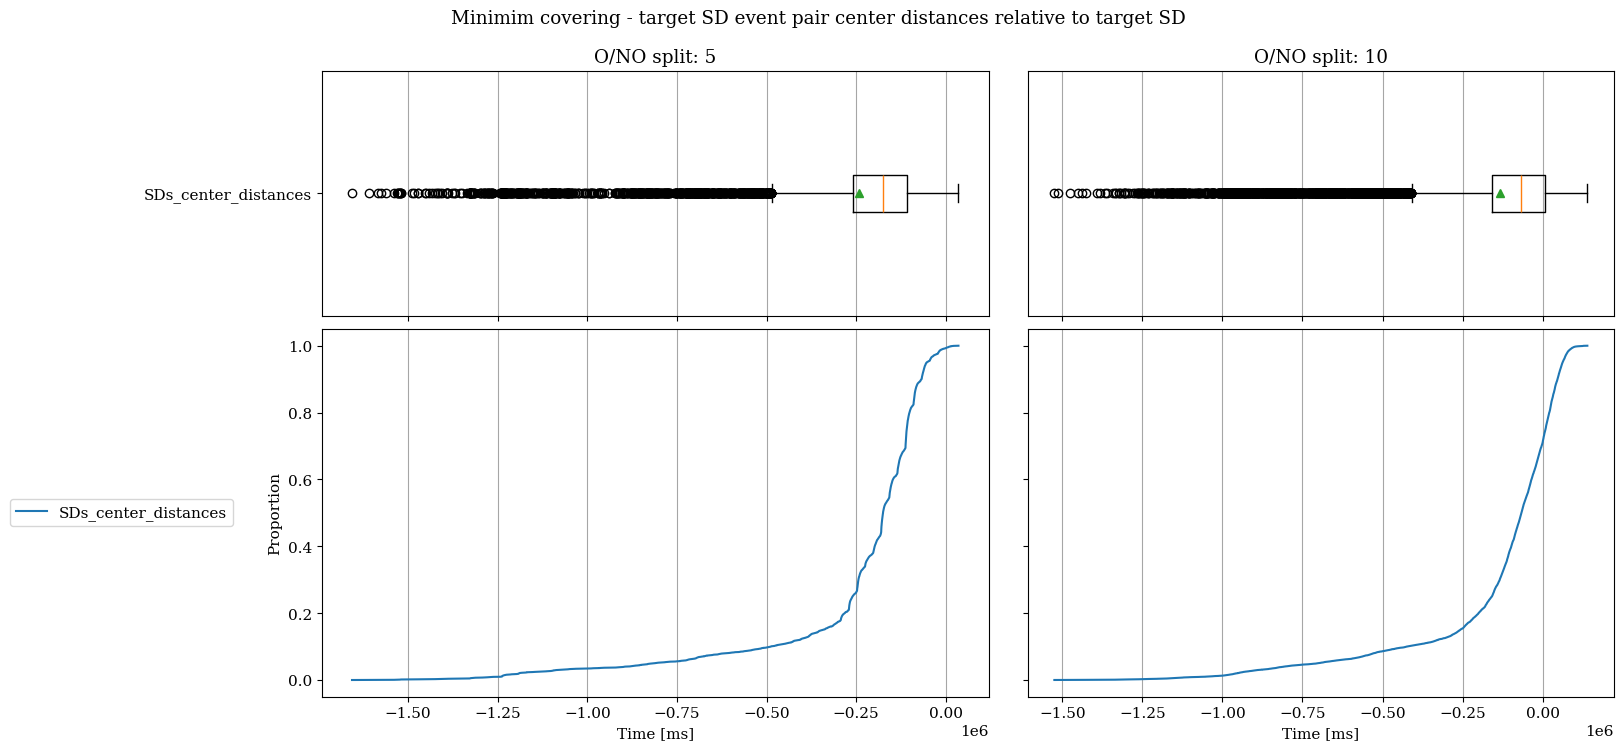

In [22]:
plot_boxplots_ecdfs(xlabel='Time [ms]',
                    title='Minimim covering - target SD event pair center distances relative to target SD',
                    filename='plots/inter_stats_used/SD_center_distances',
                    get_datas=get_datas_min,
                    to_plot = ['SDs_center_distances'],
                    labels = ['SDs_center_distances'],
                    log_xscale=False
                   )

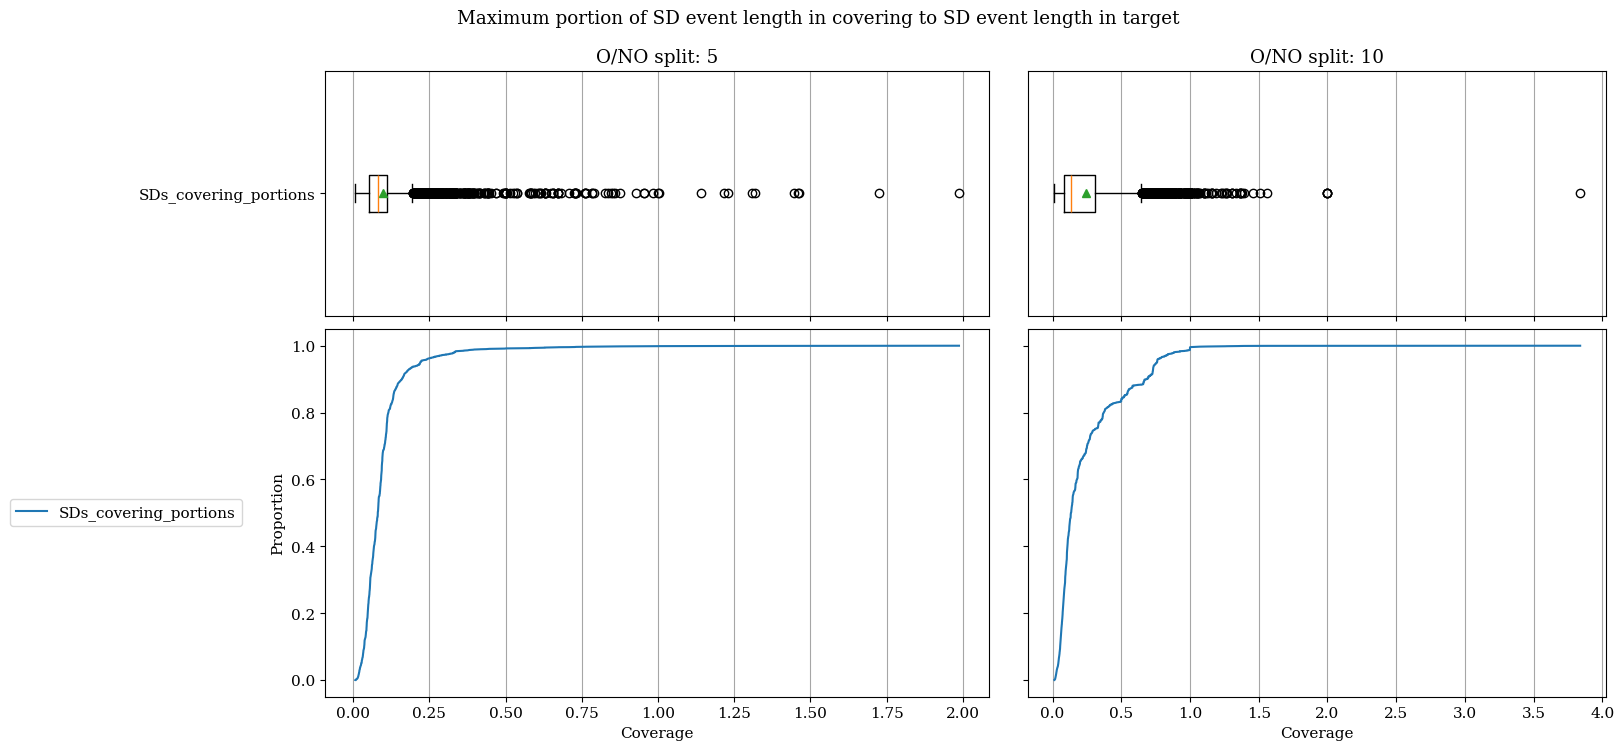

In [23]:
plot_boxplots_ecdfs(xlabel='Coverage',
                    title='Maximum portion of SD event length in covering to SD event length in target',
                    filename='plots/inter_stats_used/SD_coverages',
                    get_datas=get_datas_min,
                    to_plot = ['SDs_covering_portions'],
                    labels = ['SDs_covering_portions'],
                    log_xscale=False
                   )